In [11]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import tensorflow as tf
import matplotlib.pyplot as plt

s3 = boto3.resource('s3')
bucket_name = "rachaeld-data445"
bucket = s3.Bucket(bucket_name)

file_key = 'framingham.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the data-file
heart = pd.read_csv(file_content_stream)
heart.head()

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [12]:
# removing observations with NA
heart = heart.dropna()

In [13]:
# defining the input and target variables
X = heart[['age', 'currentSmoker','totChol', 'BMI', 'heartRate']]
Y = heart['TenYearCHD']

# splitting the data
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = .2)

In [14]:
# min-max transformation
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [18]:
#lists for results 
md1results = list()
md2results = list()
md3results = list()
md4results = list()

#running each model 100 times 
for i in range (0,100):
    #splitting
    X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = .2)
    
    # min-max transformation
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
### model 1 ###
    # defining the model
    md1 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4, input_dim = 5, activation= 'tanh'),
        tf.keras.layers.Dense(2, activation = 'softmax')
    ])
    md1.compile(optimizer='sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    md1.fit(X_train, tf.keras.utils.to_categorical(Y_train, num_classes = 2), epochs = 100, batch_size= 500, verbose = 0)
    # predicting on test
    md1pred = md1.predict(X_test)[:, 1]
    # cut off at 15%
    md1labels = np.where(md1pred < .15, 0, 1)
    #computing the recall score
    md1recall = recall_score(Y_test, md1labels)
    md1results.append(md1recall)

### model 2 ###
    # defining the model
    md2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4, input_dim = 5, activation= 'relu'),
        tf.keras.layers.Dense(2, activation = 'softmax')
    ])
    md2.compile(optimizer='sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    md2.fit(X_train, tf.keras.utils.to_categorical(Y_train, num_classes = 2), epochs = 100, batch_size= 500, verbose = 0)
    #predicting on test
    md2pred = md2.predict(X_test)[:, 1]
    #cut off at 15%
    md2labels = np.where(md2pred < .15, 0, 1)
    #computing the recall score
    md2recall = recall_score(Y_test, md2labels)
    md2results.append(md2recall)

### model 3 ###
    #First SVC Model 
    svm_model3 = SVC(kernel = 'rbf', probability = True).fit(X_train, Y_train)
    #predicting on test
    svm3_pred = svm_model3.predict_proba(X_test)[:,1]
    #cut off at 15%
    svm3_labels = np.where(svm3_pred < .15, 0, 1)
    #computing the recall score
    svm3_recall = recall_score(Y_test, svm3_labels)
    md3results.append(svm3_recall)
    
### model 4 ###
    #Second SVC Model 
    svm_model4 = SVC(kernel = 'poly', probability = True).fit(X_train, Y_train)
    #predicting on test
    svm4_pred = svm_model4.predict_proba(X_test)[:,1]
    #cut off at 15%
    svm4_labels = np.where(svm4_pred < .15, 0, 1)
    #computing the recall score
    svm4_recall = recall_score(Y_test, svm4_labels)
    md4results.append(svm4_recall)
    
print('The average recall for model 1 is', np.mean(md1results))
print('The average recall for model 2 is',np.mean(md2results))
print('The average recall for model 3 is',np.mean(md3results))
print('The average recall for model 4 is',np.mean(md4results))    
    

The average recall for model 1 is 0.5408637998635543
The average recall for model 2 is 0.6697635368035425
The average recall for model 3 is 0.6382686473245531
The average recall for model 4 is 0.5639471812686669


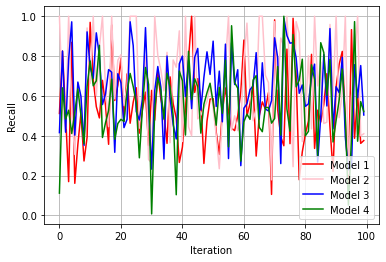

In [27]:
x= [i for i in range(0,100)]
plt.plot(x, md1results, color = 'red', label = 'Model 1')
plt.plot(x, md2results, color = 'pink', label = 'Model 2')
plt.plot(x, md3results, color = 'blue', label = 'Model 3')
plt.plot(x, md4results, color = 'green', label = 'Model 4')
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.legend(loc = 'lower right')
plt.grid()
plt.show();